# Spiking Neural Systems

From: https://tutorials.sciml.ai/html/models/08-spiking_neural_systems.html

Neuron models of leaky integrate-and-fire (LIF), Izhikevich, and Hodgkin-Huxley.

## The Leaky Integrate-and-Fire (LIF) Model

$C\dot{u} = -g_L (u - E_L) + I$

- $u$: membrane potential (voltage)
- $g_L$ : leak conductance
- $I$: input current
- $E_L$: equilibrium potential
- $C$: membrane capacitance

In [1]:
using DifferentialEquations
using Plots
Plots.gr(lw=2)

function lif(u, p, t);
    gL, EL, C, Vth, I = p
    return (-gL * (u - EL) + I) / C
end

lif (generic function with 1 method)

And when the membrane potential reaches a threshold, an action potential (spike) will occur and the membrane potential resets. The events can be described by a `DiscreteCallback`.

In [2]:
function thr_cond(u, t, integrator)
    integrator.u > integrator.p[4]
end

function reset_affect!(integrator)
    integrator.u = integrator.p[2]
end

threshold = DiscreteCallback(thr_cond, reset_affect!)
current_step= PresetTimeCallback([10.0, 25.0], integrator -> integrator.p[5] += 210.0)
cb = CallbackSet(current_step, threshold)

u0 = -75
tspan = (0.0, 40.0)
# p = (gL, EL, C, Vth, I)
p = [10.0, -75.0, 5.0, -55.0, 0]

prob = ODEProblem(lif, u0, tspan, p, callback=cb)

ODEProblem with uType Int64 and tType Float64. In-place: false
timespan: (0.0, 40.0)
u0: -75

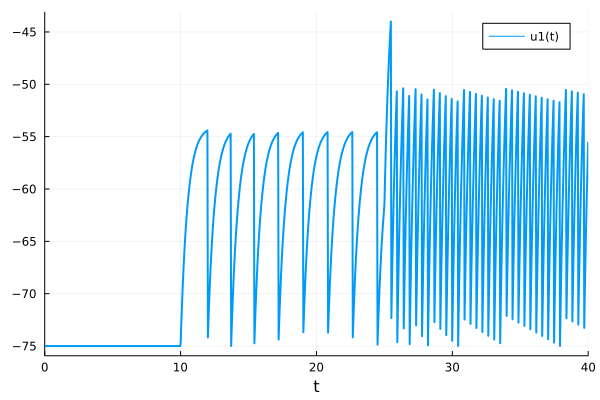

In [3]:
sol = solve(prob)

plot(sol)

The model is resting at `-75` while there is no input. At `t=10` the input increases by `210` and the model starts to spike. Spiking does not start immediately because the input first has to charge the membrane capacitance. Increasing the input again at `t=15` increases the firing rate. Note that the firing is extremely regular because LIF model is just a simple RC circuit.

## The Izhikevich Model

[The Izhikevich model](https://www.izhikevich.org/publications/spikes.htm) is a neuronal spiking model with two state variable. It can generate more complex patterns than the LIF model.

$$
\begin{aligned}
\dot{v} &= 0.04v^2 + 5 v + 140 - u + I \\
\dot{u} &= a (bv - u)
\end{aligned}
$$

When $v \geq$ 30 mV, $v$ resets to $c$, $u$ increased by $d$.

In [4]:
#Izhikevichch Model
using DifferentialEquations
using Plots

# In-place form of model
function izh!(du, u, p, t);
    a, b, c, d, I = p

    du[1] = 0.04 * u[1]^2 + 5 * u[1] + 140 - u[2] + I
    du[2] = a * (b * u[1] - u[2])
end

function thr_cond(u,t,integrator)
    integrator.u[1] >= 30
end

function reset_affect!(integrator)
    integrator.u[1] = integrator.p[3]
    integrator.u[2] += integrator.p[4]
end

threshold = DiscreteCallback(thr_cond, reset_affect!)
current_step= PresetTimeCallback(50, integrator -> integrator.p[5] += 10)
cb = CallbackSet(current_step, threshold)

p = [0.02, 0.2, -50, 2, 0]
u0 = [-65, p[2]*-65]
tspan = (0.0, 300)

prob = ODEProblem(izh!, u0, tspan, p, callback=cb)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 300.0)
u0: 2-element Vector{Float64}:
 -65.0
 -13.0

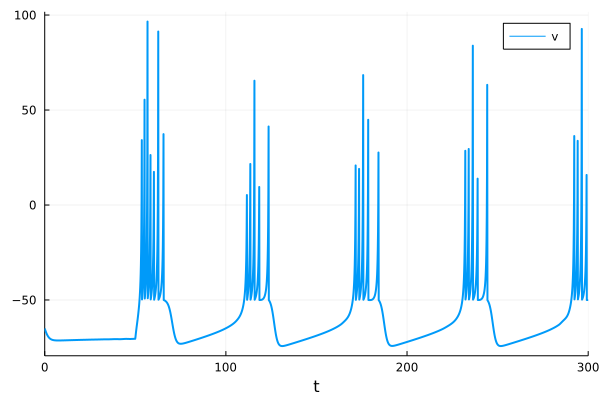

In [5]:
sol = solve(prob)
plot(sol, vars=1, label="v")

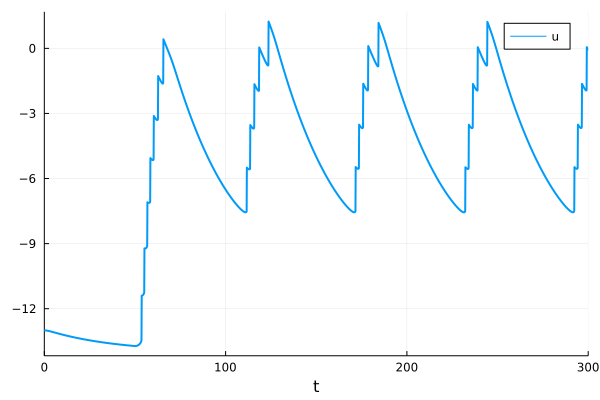

In [6]:
plot(sol, vars=2, label="u")

Changing parameters alters the spiking patterns.

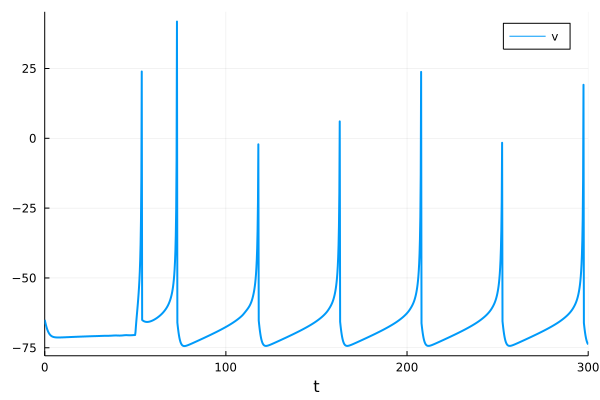

In [7]:
p = [0.02, 0.2, -65, 8, 0]
u0 = [-65, p[2]*-65]
tspan = (0.0, 300)

prob = ODEProblem(izh!, u0, tspan, p, callback=cb)
sol = solve(prob)

plot(sol, vars=1, label="v")

## Hodgkin-Huxley Model

The [Hodgkin-Huxley (HH) model](https://en.wikipedia.org/wiki/Hodgkin%E2%80%93Huxley_model) is a biophysically realistic neuron model. All parameters and mechanisms of the model represent biological mechanisms. Opeing and closing of sodium and potassium channels depolarize and hyperpolarize the membrane potential.

In [8]:
using DifferentialEquations
using Plots

# Potassium ion-channel rate functions
alpha_n(v) = (0.02 * (v - 25.0)) / (1.0 - exp((-1.0 * (v - 25.0)) / 9.0))
beta_n(v) = (-0.002 * (v - 25.0)) / (1.0 - exp((v - 25.0) / 9.0))

# Sodium ion-channel rate functions
alpha_m(v) = (0.182*(v + 35.0)) / (1.0 - exp((-1.0 * (v + 35.0)) / 9.0))
beta_m(v) = (-0.124 * (v + 35.0)) / (1.0 - exp((v + 35.0) / 9.0))

alpha_h(v) = 0.25 * exp((-1.0 * (v + 90.0)) / 12.0)
beta_h(v) = (0.25 * exp((v + 62.0) / 6.0)) / exp((v + 90.0) / 12.0)

function HH!(du,u,p,t)
    gK, gNa, gL, EK, ENa, EL, C, I = p
    v, n, m, h = u

    du[1] = (-(gK * (n^4.0) * (v - EK)) - (gNa * (m ^ 3.0) * h * (v - ENa)) - (gL * (v - EL)) + I) / C
    du[2] = (alpha_n(v) * (1.0 - n)) - (beta_n(v) * n)
    du[3] = (alpha_m(v) * (1.0 - m)) - (beta_m(v) * m)
    du[4] = (alpha_h(v) * (1.0 - h)) - (beta_h(v) * h)
end

HH! (generic function with 1 method)

In [9]:
current_step= PresetTimeCallback(100, integrator -> integrator.p[8] += 1)

# n, m & h steady-states
n_inf(v) = alpha_n(v) / (alpha_n(v) + beta_n(v))
m_inf(v) = alpha_m(v) / (alpha_m(v) + beta_m(v))
h_inf(v) = alpha_h(v) / (alpha_h(v) + beta_h(v))

# gK, gNa, gL, EK, ENa, EL, C, I
p = [35.0, 40.0, 0.3, -77.0, 55.0, -65.0, 1, 0]
u0 = [-60, n_inf(-60), m_inf(-60), h_inf(-60)]
tspan = (0.0, 1000.0)

prob = ODEProblem(HH!, u0, tspan, p, callback=current_step)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 1000.0)
u0: 4-element Vector{Float64}:
 -60.0
   0.0007906538330645917
   0.08362733690208038
   0.41742979353768533

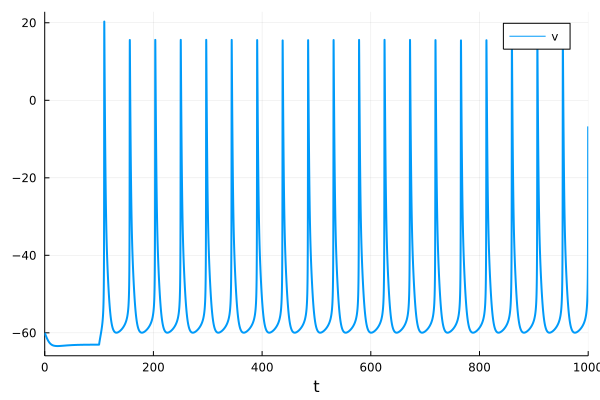

In [10]:
sol = solve(prob)
plot(sol, vars=1, label="v")

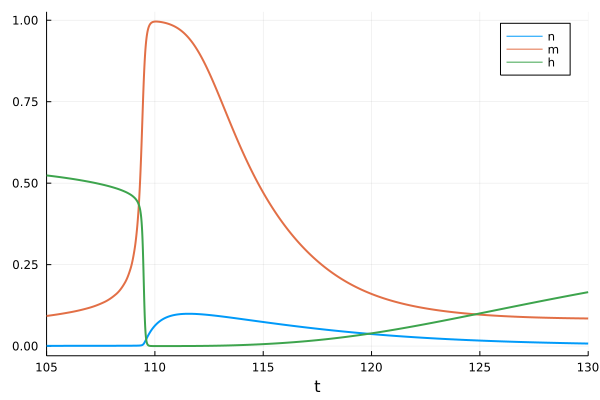

In [11]:
plot(sol, vars=[2, 3, 4], tspan=(105.0, 130.0), label=["n" "m" "h"])

## Alpha Synapse

One of the most simple synaptic mechanisms used in computational neuroscience is the alpha synapse. When this mechanism is triggered, it causes an instantanouse rise in conductance followed by an exponential decay.

In [12]:
gSyn(max_gsyn, tau, tf, t) = ifelse(t - tf >= 0, max_gsyn * exp(-(t - tf)/tau), 0.0)

function HH_syn!(du,u,p,t)
    gK, gNa, gL, EK, ENa, EL, C, I, max_gSyn, ESyn, tau, tf = p
    v, n, m, h = u

    ISyn = gSyn(max_gSyn, tau, tf, t) * (v - ESyn)

    du[1] = (-(gK * (n^4.0) * (v - EK)) - (gNa * (m ^ 3.0) * h * (v - ENa)) - (gL * (v - EL)) + I - ISyn) / C
    du[2] = (alpha_n(v) * (1.0 - n)) - (beta_n(v) * n)
    du[3] = (alpha_m(v) * (1.0 - m)) - (beta_m(v) * m)
    du[4] = (alpha_h(v) * (1.0 - h)) - (beta_h(v) * h)
end

HH_syn! (generic function with 1 method)

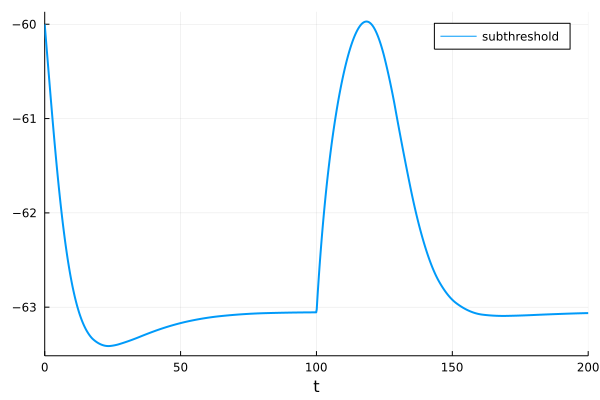

In [13]:
# gK, gNa, gL, EK, ENa, EL, C, I, max_gSyn, ESyn, tau, tf
p = [35.0, 40.0, 0.3, -77.0, 55.0, -65.0, 1, 0, 0.008, 0, 20, 100]
tspan = (0.0, 200.0)
prob = ODEProblem(HH_syn!, u0, tspan, p)
sol = solve(prob)
plot(sol, vars=1, label="subthreshold")

Subthreshold excitatory postsynaptic potential (EPSP) (blue) vs suprathreshold EPSP (orange).

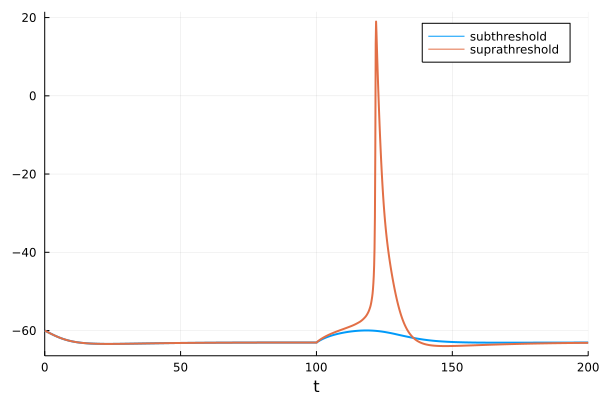

In [14]:
# Increasing max_gSyn from 0.008 to 0.01
sol2 = solve(remake(prob, p = [35.0, 40.0, 0.3, -77.0, 55.0, -65.0, 1, 0, 0.01, 0, 20, 100]))
plot!(sol2, vars=1, label="suprathreshold")

## Tsodyks-Markram Synapse

The Tsodyks-Markram synapse (TMS) is a dynamic system that models the changes of maximum conductance that occur between EPSPs at different firing frequencies.

In [15]:
function HH_tms!(du, u, p, t)
    gK, gNa, gL, EK, ENa, EL, C, I, tau, tau_u, tau_R, u0, gmax, Esyn  = p
    v, n, m, h, u, R, gsyn = u

    du[1] = ((gK * (n^4.0) * (EK - v)) + (gNa * (m ^ 3.0) * h * (ENa - v)) + (gL * (EL - v)) + I + gsyn * (Esyn - v)) / C
    du[2] = (alpha_n(v) * (1.0 - n)) - (beta_n(v) * n)
    du[3] = (alpha_m(v) * (1.0 - m)) - (beta_m(v) * m)
    du[4] = (alpha_h(v) * (1.0 - h)) - (beta_h(v) * h)

    # Synaptic variables
    du[5] = -(u / tau_u)
    du[6] = (1-R) / tau_R
    du[7] = -(gsyn / tau)
end

function epsp!(integrator)
    integrator.u[5] += integrator.p[12] * (1 - integrator.u[5])
    integrator.u[7] += integrator.p[13] * integrator.u[5] * integrator.u[6]
    integrator.u[6] -= integrator.u[5] * integrator.u[6]

end

epsp_ts= PresetTimeCallback(100:100:500, epsp!)

# gK, gNa, gL, EK, ENa, EL, C, I, tau, tau_u, tau_R, u0, gmax, Esyn
p = [35.0, 40.0, 0.3, -77.0, 55.0, -65.0, 1, 0, 30, 1000, 50, 0.5, 0.005, 0]
u0 = [-60, n_inf(-60), m_inf(-60), h_inf(-60), 0.0, 1.0, 0.0]
tspan = (0.0, 700.0)
prob = ODEProblem(HH_tms!, u0, tspan, p, callback=epsp_ts)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 700.0)
u0: 7-element Vector{Float64}:
 -60.0
   0.0007906538330645917
   0.08362733690208038
   0.41742979353768533
   0.0
   1.0
   0.0

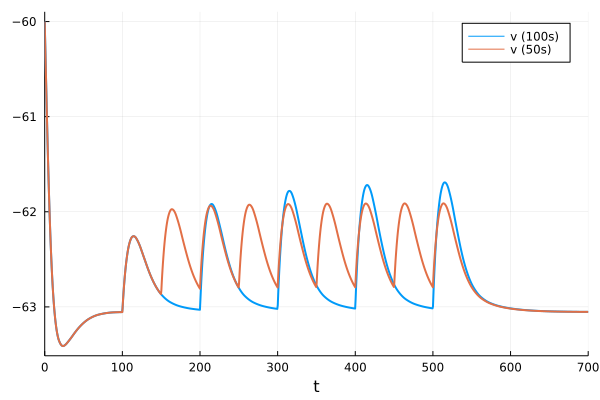

In [16]:
sol = solve(prob)
plot(sol, vars=1, label="v (100s)")

prob2 = ODEProblem(HH_tms!, u0, tspan, p, callback= PresetTimeCallback(100:50:500, epsp!))

sol2 = solve(prob2)
plot!(sol2, vars=1, label="v (50s)")

An increase in peak conductance over multiple synaptic events.

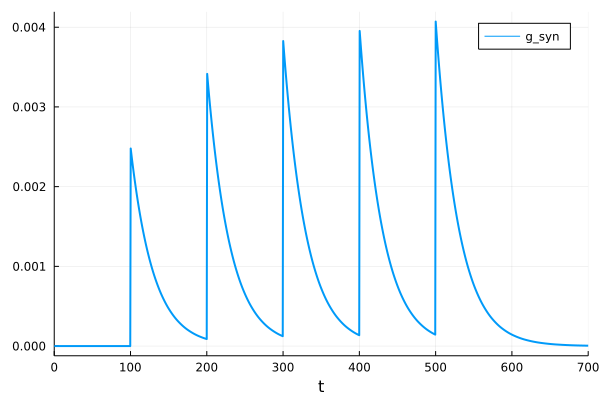

In [17]:
plot(sol, vars=7, label="g_syn")

If we increase the period between these events, facilitation does not occur.

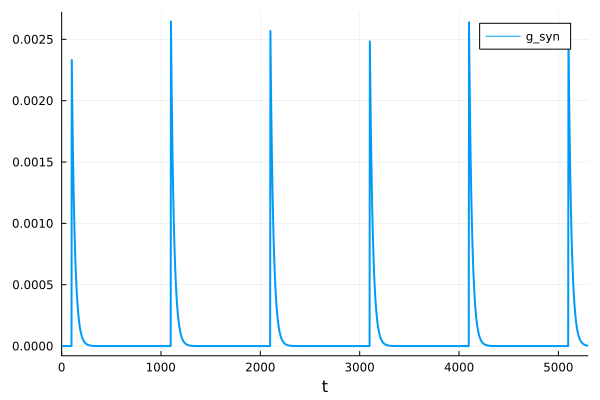

In [18]:
p = [35.0, 40.0, 0.3, -77.0, 55.0, -65.0, 1, 0, 30, 500, 50, 0.5, 0.005, 0]
u0 = [-60, n_inf(-60), m_inf(-60), h_inf(-60), 0.0, 1.0, 0.0]
tspan = (0.0, 5300.0)
prob = ODEProblem(HH_tms!, u0, tspan, p, callback= PresetTimeCallback(100:1000:5100, epsp!))
sol = solve(prob)
plot(sol, vars=7, label="g_syn")

We can also change these time constants such that the dynamics show short-term depression instead of facilitation.

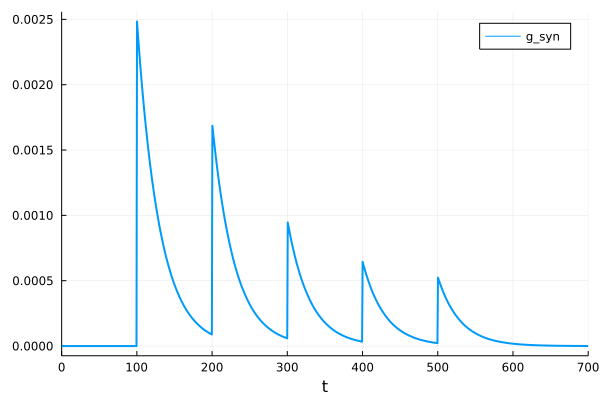

In [19]:
epsp_ts = PresetTimeCallback(100:100:500, epsp!)
p = [35.0, 40.0, 0.3, -77.0, 55.0, -65.0, 1, 0, 30, 100, 1000, 0.5, 0.005, 0]
u0 = [-60, n_inf(-60), m_inf(-60), h_inf(-60), 0.0, 1.0, 0.0]
tspan = (0.0, 700.0)
prob = ODEProblem(HH_tms!, u0, tspan, p, callback=epsp_ts)
sol = solve(prob)
plot(sol, vars=7, label="g_syn")